# 5. Criação de Modelos de Machine Learning

## Carregar dados tratados

In [35]:
# ! pip install seaborn
# ! pip install plotly
# ! pip install statsmodels
# ! pip install sklearn

In [36]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import make_scorer, precision_score
from sklearn import metrics

import joblib

In [37]:
def carregar_joblib(file_name: str = "../out/result_analise_desc.joblib"):
    df = joblib.load(file_name)
    return df

## Feature selection

In [38]:
def ajustar_scaler(tabela_original):
    scaler = StandardScaler()
    tabela_auxiliar = tabela_original.drop("decisao", axis=1)
    
    tabela_auxiliar = pd.DataFrame(scaler.fit_transform(tabela_auxiliar), tabela_auxiliar.index, tabela_auxiliar.columns)
    tabela_auxiliar["decisao"] = tabela_original["decisao"]
    
    return tabela_auxiliar

In [39]:
def print_feature_selection_extra_trees(df):
    modelo = ExtraTreesClassifier(random_state=1)
    x = df.drop("decisao", axis=1)
    y = df["decisao"]
    modelo.fit(x, y)

    caracteristicas_importantes = pd.DataFrame(modelo.feature_importances_, x.columns).sort_values(by=0, ascending=False)
    print(caracteristicas_importantes)

In [40]:
def split_dados(df):
    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, random_state=42)

    print(f"\n{len(X_treino)=} {len(X_teste)=} {len(y_treino)=} {len(y_teste)=}\n")

    return X_treino, X_teste, y_treino, y_teste

In [41]:
def split_dados_cv(df, model: dict):
    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    from sklearn import model_selection
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import KFold

    # skfold = model_selection.StratifiedKFold(n_splits=5)

    # results_skfold = model_selection.cross_val_score(model, X, y, cv=skfold)
    # display(results_skfold)
    # print("Accuracy: %.2f%%" % (results_skfold.mean()*100.0))

    kfold = KFold(n_splits=5, random_state=42, shuffle=True)

    accuracy_and_data = []

    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X.iloc[train_idx,:], X.iloc[test_idx, :]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        previsoes = model.predict(X_test)

        acc = accuracy_score(previsoes, y_test)
        accuracy_and_data.append({'accuracy': acc, 'split_data': (X_train, X_test, y_train, y_test)})
        
        avaliar(y_test, previsoes, "logReg")
    
    

# ML modelos

## Modelos a serem testados

- AdaBoost
- Decision Tree
- Random Forest
- ExtraTree
- Gradient Boost
- K Nearest Neighbors (KNN)
- Logistic Regression
- Rede Neural

In [42]:
svc=SVC(probability=True, kernel='linear')
log = LogisticRegression(random_state=42)
log_reg = LogisticRegression(C=1.0, max_iter=100, tol=0.0001, random_state=1, solver="newton-cg",
                                fit_intercept=True, intercept_scaling=1, l1_ratio=None, penalty="none", warm_start=False)

def definir_modelos_ml() -> dict:
    modelos = {
        # "XGBoost": XGBClassifier(max_depth=9, scale_pos_weight=0.2),
        "AdaBoost": AdaBoostClassifier(random_state=42),
        "DecisionTree": DecisionTreeClassifier(random_state=42),
        "RandomForest": RandomForestClassifier(random_state=42),
        "ExtraTree": ExtraTreesClassifier(random_state=42),
        "GradientBoost": GradientBoostingClassifier(random_state=42),
        # "KNN": KNeighborsClassifier(),
        # "LogisticRegression": LogisticRegression(C=1.0, max_iter=100, tol=0.0001, random_state=1, solver="newton-cg",
                                # fit_intercept=True, intercept_scaling=1, l1_ratio=None, penalty="none", warm_start=False),
        # "LogisticRegression": LogisticRegression(C=1.0, max_iter=100, tol=0.0001, random_state=1, solver="newton-cg"),
        # "LogisticRegression": LogisticRegression(random_state=42),
        # "RedeNeural": MLPClassifier(random_state= 42),
        # "RedeNeural": MLPClassifier(solver= "sgd", random_state= 2, hidden_layer_sizes= 5),
    }
    print(f"\nModelos a serem comparados: {[v for v in modelos.keys()]}\n")
    return modelos



In [43]:
def rodar_imprimir_modelos_ml(modelos, X_treino, X_teste, y_treino, y_teste, df):
    X = df.drop("decisao", axis=1)
    y = df["decisao"]
    for nome, modelo in modelos.items():
        modelo.fit(X_treino, y_treino)
        previsoes = modelo.predict(X_teste)
        
        predict_all = modelo.predict(X)
        avaliar(y, predict_all, f"{nome} Base inteira")
        avaliar(y_teste, previsoes, f"{nome} Teste")
        modelos[nome] = modelo
    
    return modelos

In [44]:
def avaliar(y_teste, y_pred, nome_modelo):
    print(nome_modelo)
    report = classification_report(y_teste, y_pred)
    print(report)
    cf_matrix = pd.DataFrame(confusion_matrix(y_teste, y_pred), index=["Vender", "Comprar"], columns=["Vender", "Comprar"])
    sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt=',')
    plt.show()
    print("Accuracy:", metrics.accuracy_score(y_teste, y_pred))
    print("#" * 50)
    
    


# Execucao

Carregado df com 1852 linhas e 6 colunas.

Colunas carregadas: ['outros_ativos_circ', 'receita_liq', 'despesas_gerais', 'resultado_antes_trib', 'lucro_op', 'decisao']



len(X_treino)=1389 len(X_teste)=463 len(y_treino)=1389 len(y_teste)=463

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

Modelos a serem comparados: ['AdaBoost', 'DecisionTree', 'RandomForest', 'ExtraTree', 'GradientBoost']

AdaBoost Base inteira
              precision    recall  f1-score   support

           0       0.66      0.52      0.58       923
           1       0.60      0.73      0.66       929

    accuracy                           0.62      1852
   macro avg       0.63      0.62      0.62      1852
weighted avg       0.63      0.62      0.62      1852



/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


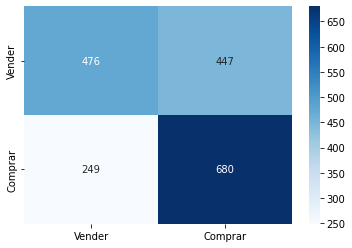

Accuracy: 0.6241900647948164
##################################################
AdaBoost Teste
              precision    recall  f1-score   support

           0       0.59      0.46      0.51       235
           1       0.54      0.67      0.60       228

    accuracy                           0.56       463
   macro avg       0.57      0.56      0.56       463
weighted avg       0.57      0.56      0.56       463



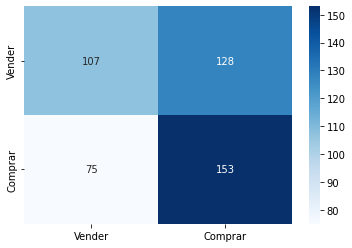

Accuracy: 0.5615550755939525
##################################################
DecisionTree Base inteira
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       923
           1       0.88      0.89      0.89       929

    accuracy                           0.89      1852
   macro avg       0.89      0.89      0.89      1852
weighted avg       0.89      0.89      0.89      1852



/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


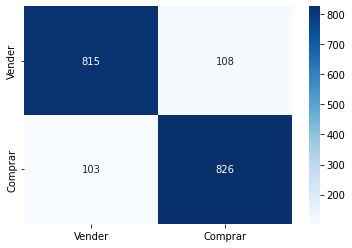

Accuracy: 0.8860691144708424
##################################################
DecisionTree Teste
              precision    recall  f1-score   support

           0       0.55      0.54      0.55       235
           1       0.54      0.55      0.54       228

    accuracy                           0.54       463
   macro avg       0.54      0.54      0.54       463
weighted avg       0.54      0.54      0.54       463



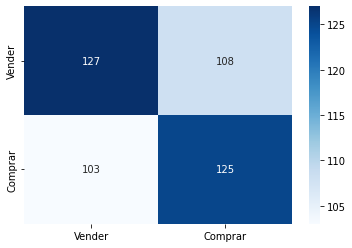

Accuracy: 0.5442764578833693
##################################################


/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RandomForest Base inteira
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       923
           1       0.88      0.89      0.88       929

    accuracy                           0.88      1852
   macro avg       0.88      0.88      0.88      1852
weighted avg       0.88      0.88      0.88      1852



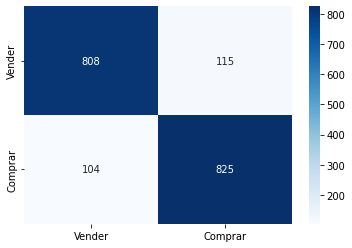

Accuracy: 0.8817494600431965
##################################################
RandomForest Teste
              precision    recall  f1-score   support

           0       0.54      0.51      0.52       235
           1       0.52      0.54      0.53       228

    accuracy                           0.53       463
   macro avg       0.53      0.53      0.53       463
weighted avg       0.53      0.53      0.53       463



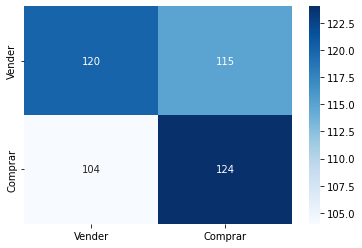

Accuracy: 0.5269978401727862
##################################################


/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(


ExtraTree Base inteira
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       923
           1       0.88      0.90      0.89       929

    accuracy                           0.89      1852
   macro avg       0.89      0.89      0.89      1852
weighted avg       0.89      0.89      0.89      1852



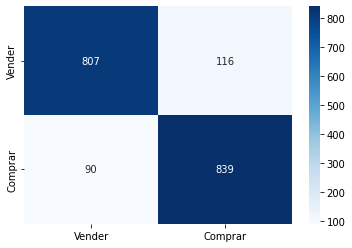

Accuracy: 0.8887688984881209
##################################################
ExtraTree Teste
              precision    recall  f1-score   support

           0       0.57      0.51      0.54       235
           1       0.54      0.61      0.57       228

    accuracy                           0.56       463
   macro avg       0.56      0.56      0.55       463
weighted avg       0.56      0.56      0.55       463



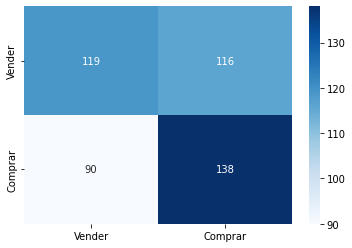

Accuracy: 0.5550755939524838
##################################################
GradientBoost Base inteira
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       923
           1       0.70      0.78      0.74       929

    accuracy                           0.72      1852
   macro avg       0.72      0.72      0.72      1852
weighted avg       0.72      0.72      0.72      1852



/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


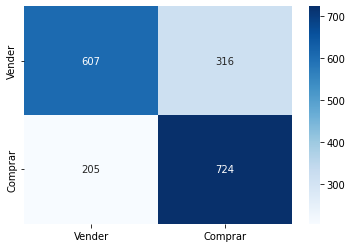

Accuracy: 0.718682505399568
##################################################
GradientBoost Teste
              precision    recall  f1-score   support

           0       0.59      0.51      0.55       235
           1       0.56      0.63      0.59       228

    accuracy                           0.57       463
   macro avg       0.57      0.57      0.57       463
weighted avg       0.57      0.57      0.57       463



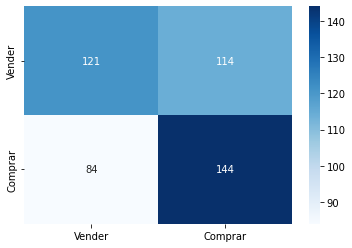

Accuracy: 0.572354211663067
##################################################


In [45]:
def main():

    df = carregar_joblib()

    print(f"Carregado df com {df.shape[0]} linhas e {df.shape[1]} colunas.\n")
    print(f"Colunas carregadas: {[col for col in df.columns]}\n\n")

    # df = ajustar_scaler(df)

    # split database 25% test 75% train
    X_treino, X_teste, y_treino, y_teste = split_dados(df)

    print("#-" * 40)

    modelos = definir_modelos_ml()

    modelos = rodar_imprimir_modelos_ml(modelos, X_treino.values, X_teste.values, y_treino.values, y_teste.values, df)

    return df

df = main()

## 3 Melhores modelos - acuracia

- AdaBoost - 55%
- GradientBoost - 54%
- RandomForest - 53%


Carregado df com 1852 linhas e 6 colunas.

Colunas carregadas: ['outros_ativos_circ', 'receita_liq', 'despesas_gerais', 'resultado_antes_trib', 'lucro_op', 'decisao']



len(X_treino)=1389 len(X_teste)=463 len(y_treino)=1389 len(y_teste)=463

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

Modelos a serem comparados: ['AdaBoost', 'DecisionTree', 'RandomForest', 'ExtraTree', 'GradientBoost']

AdaBoost Base inteira
              precision    recall  f1-score   support

           0       0.66      0.52      0.58       923
           1       0.60      0.73      0.66       929

    accuracy                           0.62      1852
   macro avg       0.63      0.62      0.62      1852
weighted avg       0.63      0.62      0.62      1852



/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


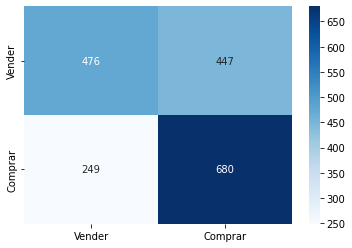

Accuracy: 0.6241900647948164
##################################################
AdaBoost Teste
              precision    recall  f1-score   support

           0       0.59      0.46      0.51       235
           1       0.54      0.67      0.60       228

    accuracy                           0.56       463
   macro avg       0.57      0.56      0.56       463
weighted avg       0.57      0.56      0.56       463



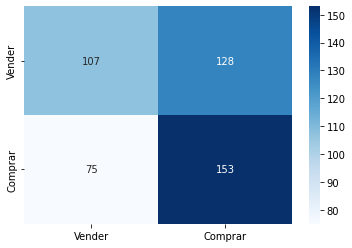

Accuracy: 0.5615550755939525
##################################################
DecisionTree Base inteira
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       923
           1       0.88      0.89      0.89       929

    accuracy                           0.89      1852
   macro avg       0.89      0.89      0.89      1852
weighted avg       0.89      0.89      0.89      1852



/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


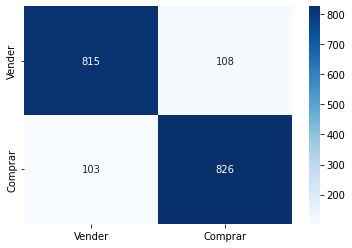

Accuracy: 0.8860691144708424
##################################################
DecisionTree Teste
              precision    recall  f1-score   support

           0       0.55      0.54      0.55       235
           1       0.54      0.55      0.54       228

    accuracy                           0.54       463
   macro avg       0.54      0.54      0.54       463
weighted avg       0.54      0.54      0.54       463



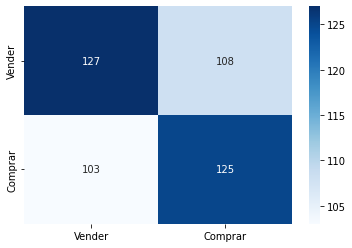

Accuracy: 0.5442764578833693
##################################################
RandomForest Base inteira
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       923
           1       0.88      0.89      0.88       929

    accuracy                           0.88      1852
   macro avg       0.88      0.88      0.88      1852
weighted avg       0.88      0.88      0.88      1852



/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


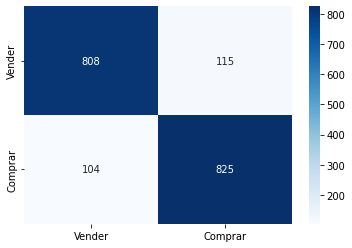

Accuracy: 0.8817494600431965
##################################################
RandomForest Teste
              precision    recall  f1-score   support

           0       0.54      0.51      0.52       235
           1       0.52      0.54      0.53       228

    accuracy                           0.53       463
   macro avg       0.53      0.53      0.53       463
weighted avg       0.53      0.53      0.53       463



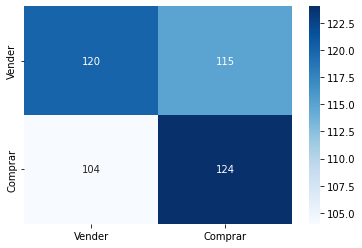

Accuracy: 0.5269978401727862
##################################################
ExtraTree Base inteira
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       923
           1       0.88      0.90      0.89       929

    accuracy                           0.89      1852
   macro avg       0.89      0.89      0.89      1852
weighted avg       0.89      0.89      0.89      1852



/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(


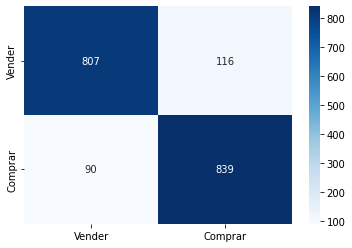

Accuracy: 0.8887688984881209
##################################################
ExtraTree Teste
              precision    recall  f1-score   support

           0       0.57      0.51      0.54       235
           1       0.54      0.61      0.57       228

    accuracy                           0.56       463
   macro avg       0.56      0.56      0.55       463
weighted avg       0.56      0.56      0.55       463



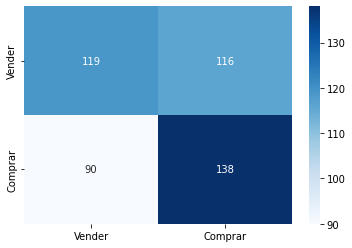

Accuracy: 0.5550755939524838
##################################################
GradientBoost Base inteira
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       923
           1       0.70      0.78      0.74       929

    accuracy                           0.72      1852
   macro avg       0.72      0.72      0.72      1852
weighted avg       0.72      0.72      0.72      1852



/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


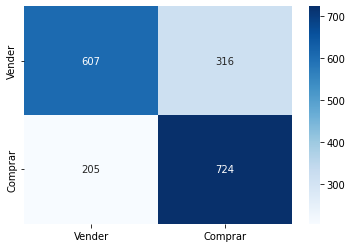

Accuracy: 0.718682505399568
##################################################
GradientBoost Teste
              precision    recall  f1-score   support

           0       0.59      0.51      0.55       235
           1       0.56      0.63      0.59       228

    accuracy                           0.57       463
   macro avg       0.57      0.57      0.57       463
weighted avg       0.57      0.57      0.57       463



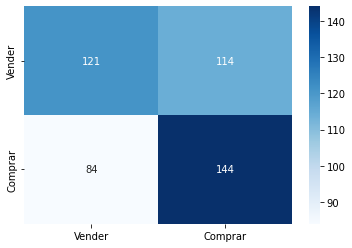

Accuracy: 0.572354211663067
##################################################


In [46]:
df = main()